# Traditional Forecasting of Volatility using the GARCH Framework

In this notebook, we forecast realized volatility using a classical econometric approach — the GARCH(1,1) model — applied to the S&P 500 index.

We begin by computing log returns from historical closing prices, then fit a GARCH(1,1) model to estimate time-varying volatility. The model captures volatility clustering and persistence, which are key characteristics of financial time series.

We then perform out-of-sample forecasting using a rolling window approach and compare the GARCH-implied volatility forecasts against realized volatility computed over a 5-day horizon. Finally, we evaluate the model's forecasting accuracy using error metrics such as RMSE, MAE, and MAPE.


In [2]:
#Import libraries 
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from tqdm import tqdm


YF.download() has changed argument auto_adjust default to True


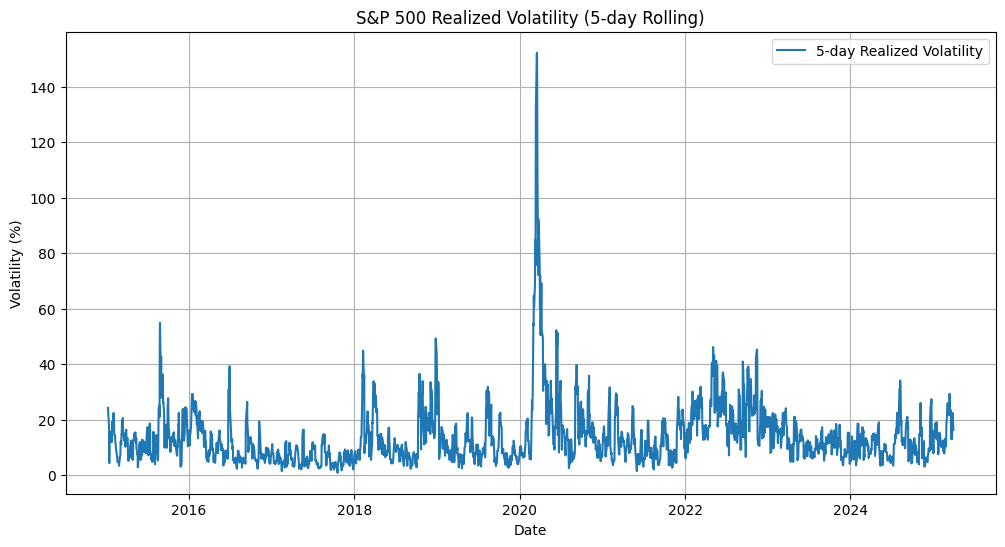

In [3]:
#Get the S&P 500 data from Yahoo Finance
data = yf.download('^GSPC', start='2015-01-01', end='2025-04-01', progress=False)
data = data.ffill()

# Use 'Close' price only
sp_500 = data['Close']

# Compute log returns in percent
log_returns = np.log(sp_500 / sp_500.shift(1)).dropna() * 100  # daily returns (%)

# Compute realized volatility (5-day rolling, annualized)
rolling_volatility_realized = log_returns.rolling(window=5).std() * np.sqrt(252)
rolling_volatility_realized = rolling_volatility_realized.dropna()

# Plot realized volatility
plt.figure(figsize=(12, 6))
plt.plot(rolling_volatility_realized, label='5-day Realized Volatility')
plt.title('S&P 500 Realized Volatility (5-day Rolling)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid()
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3319.60
Distribution:                  Normal   AIC:                           6647.20
Method:            Maximum Likelihood   BIC:                           6670.62
                                        No. Observations:                 2575
Date:                Wed, Apr 02 2025   Df Residuals:                     2574
Time:                        15:16:29   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0770  1.477e-02      5.213  1.858e-07 [4.804e-0

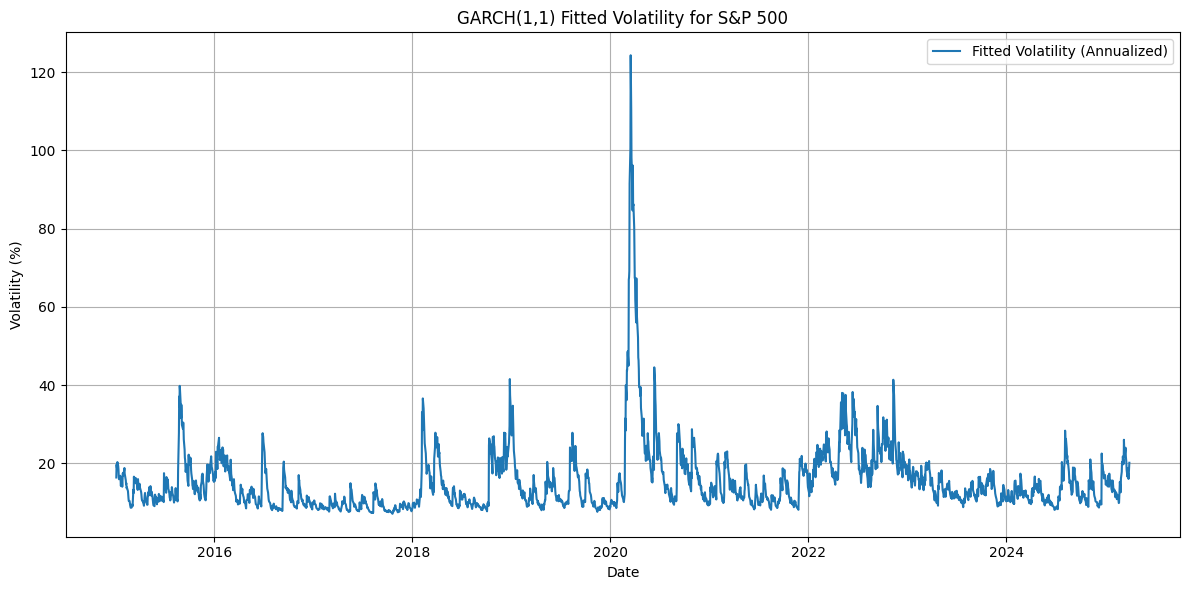

In [4]:
# Fit GARCH(1,1) in-sample
model = arch_model(log_returns, vol='Garch', p=1, q=1, dist='normal')
model_fit = model.fit(disp='off')
print(model_fit.summary())

# Plot fitted conditional volatility (in-sample)
plt.figure(figsize=(12, 6))
plt.plot(model_fit.conditional_volatility * np.sqrt(252), label='Fitted Volatility (Annualized)')
plt.title('GARCH(1,1) Fitted Volatility for S&P 500')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Out-of-Sample testing

100%|██████████| 1574/1574 [00:08<00:00, 184.13it/s]


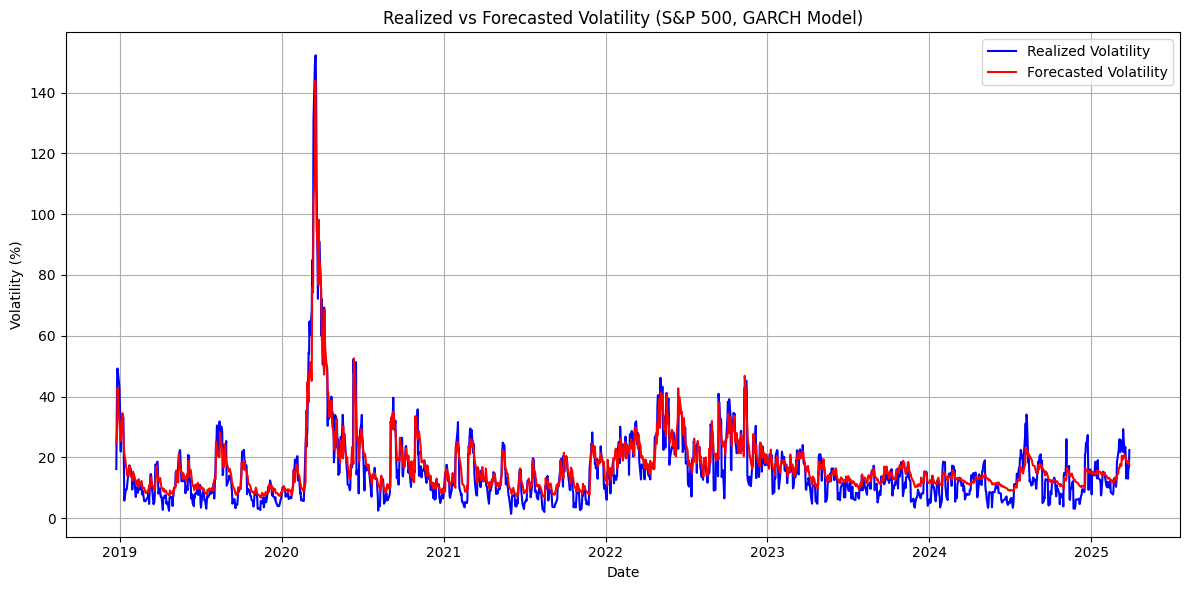

In [5]:
#Rolling forecast (out-of-sample)
window_size = 1000
num_forecasts = 1
rolling_predictions = []
forecast_dates = []

log_returns_series = log_returns.copy()

for i in tqdm(range(window_size, len(log_returns_series) - num_forecasts)):
    train_data = log_returns_series.iloc[i - window_size:i]

    try:
        model = arch_model(train_data, vol='Garch', p=1, q=1, dist='normal')
        model_fit = model.fit(disp='off')
        forecast = model_fit.forecast(horizon=num_forecasts)
        avg_var = forecast.variance.values[-1, :num_forecasts].mean()
        vol_forecast = np.sqrt(avg_var) * np.sqrt(252)
        rolling_predictions.append(vol_forecast)

        forecast_date = log_returns_series.index[i + num_forecasts - 1]
        forecast_dates.append(forecast_date)

    except Exception as e:
        print(f"⚠️ Forecast failed at index {i}: {e}")
        continue

# Create DataFrame of forecasts
rolling_predictions_df = pd.DataFrame(
    rolling_predictions,
    index=forecast_dates,
    columns=["Forecasted Volatility"]
)

# Align realized volatility
realized_vol = rolling_volatility_realized.loc[rolling_predictions_df.index]

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(realized_vol, label="Realized Volatility", color="blue")
plt.plot(rolling_predictions_df, label="Forecasted Volatility", color="red")
plt.title("Realized vs Forecasted Volatility (S&P 500, GARCH Model)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract forecasted and actual volatilities
y_true = realized_vol.values
y_pred = rolling_predictions_df["Forecasted Volatility"].values

# Compute RMSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print results
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 4.98
MAE: 3.63
MAPE: 90.42%


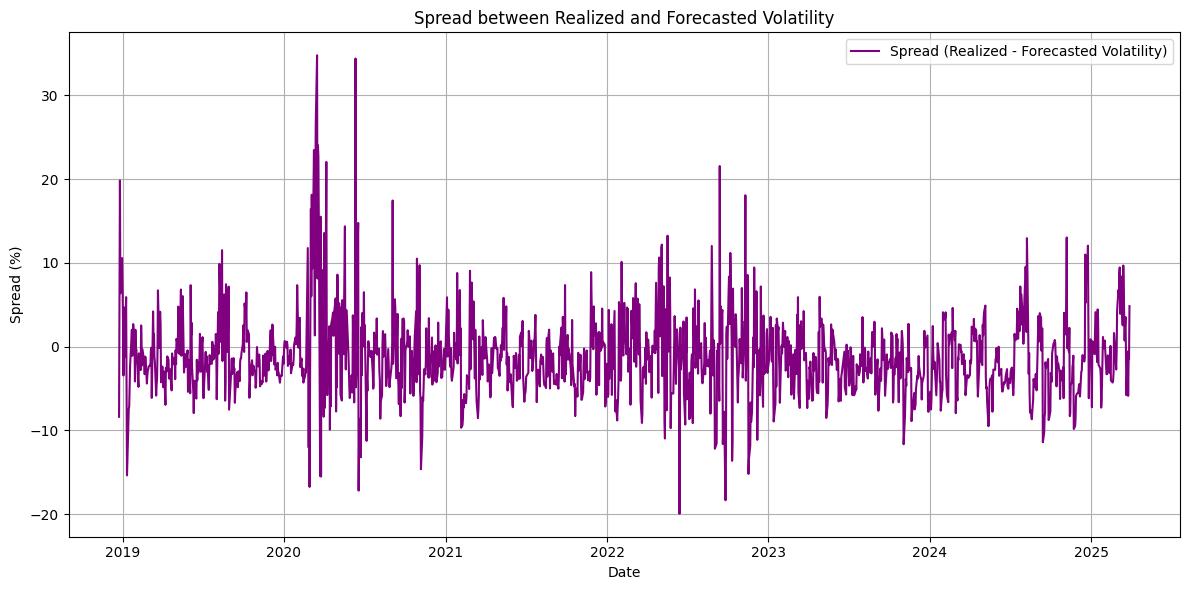

In [9]:
# Align columns for subtraction
spread = realized_vol.iloc[:, 0] - rolling_predictions_df.iloc[:, 0]

# Plot the spread
plt.figure(figsize=(12, 6))
plt.plot(spread, label="Spread (Realized - Forecasted Volatility)", color="purple")
plt.title("Spread between Realized and Forecasted Volatility")
plt.xlabel("Date")
plt.ylabel("Spread (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the 5-day realized volatility (annualized, in %)
realized_vol_series = rolling_volatility_realized.iloc[:, 0]  # Convert to Series

# Define number of lagged features to use
n_lags = 5

# Create lagged feature DataFrame
def create_lagged_features(series, n_lags=5):
    df = pd.DataFrame({'y': series})
    for i in range(1, n_lags + 1):
        df[f'y_lag{i}'] = df['y'].shift(i)
    return df.dropna()

df_rf = create_lagged_features(realized_vol_series, n_lags=n_lags)


In [13]:
window_size = 500  # how many days we use for training
predictions = []
actuals = []
forecast_index = []

for i in tqdm(range(window_size, len(df_rf))):
    train = df_rf.iloc[i - window_size:i]
    test = df_rf.iloc[i]

    X_train = train.drop(columns='y')
    y_train = train['y']
    X_test = test.drop('y').values.reshape(1, -1)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)[0]
    actual = test['y']

    predictions.append(pred)
    actuals.append(actual)
    forecast_index.append(df_rf.index[i])

  0%|          | 0/2066 [00:00<?, ?it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
  0%|          | 1/2066 [00:00<04:08,  8.32it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
  0%|          | 2/2066 [00:00<03:45,  9.15it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ran

In [14]:
y_true = np.array(actuals)
y_pred = np.array(predictions)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 4.95
MAE: 2.96
MAPE: 25.55%


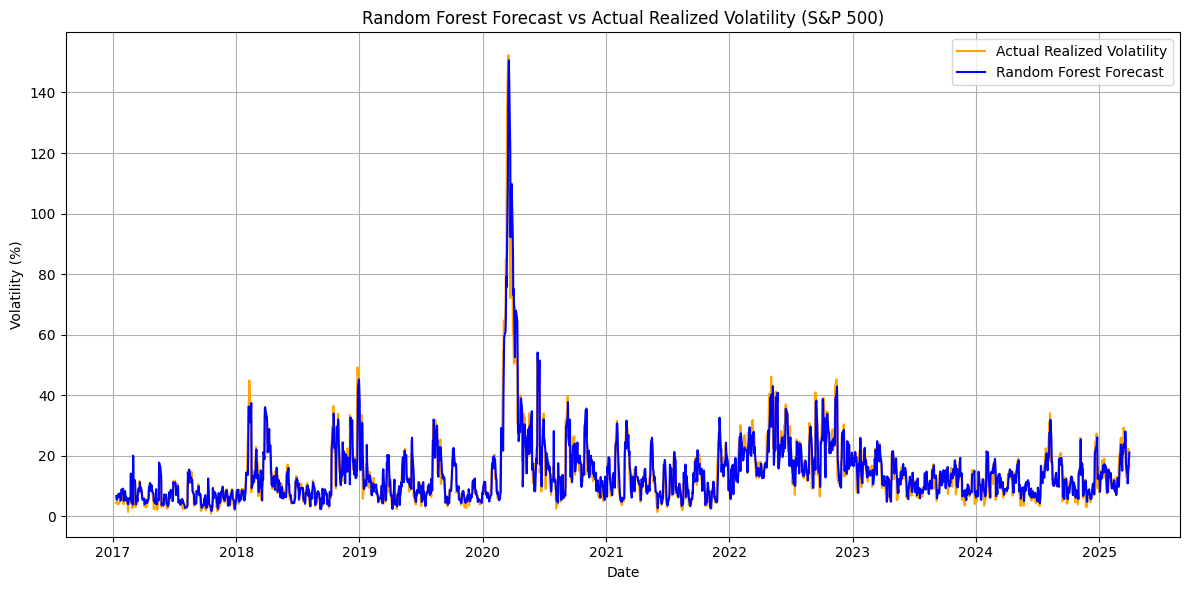

In [15]:
forecast_series = pd.Series(y_pred, index=forecast_index)
actual_series = pd.Series(y_true, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(actual_series, label='Actual Realized Volatility', color='orange')
plt.plot(forecast_series, label='Random Forest Forecast', color='blue')
plt.title("Random Forest Forecast vs Actual Realized Volatility (S&P 500)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

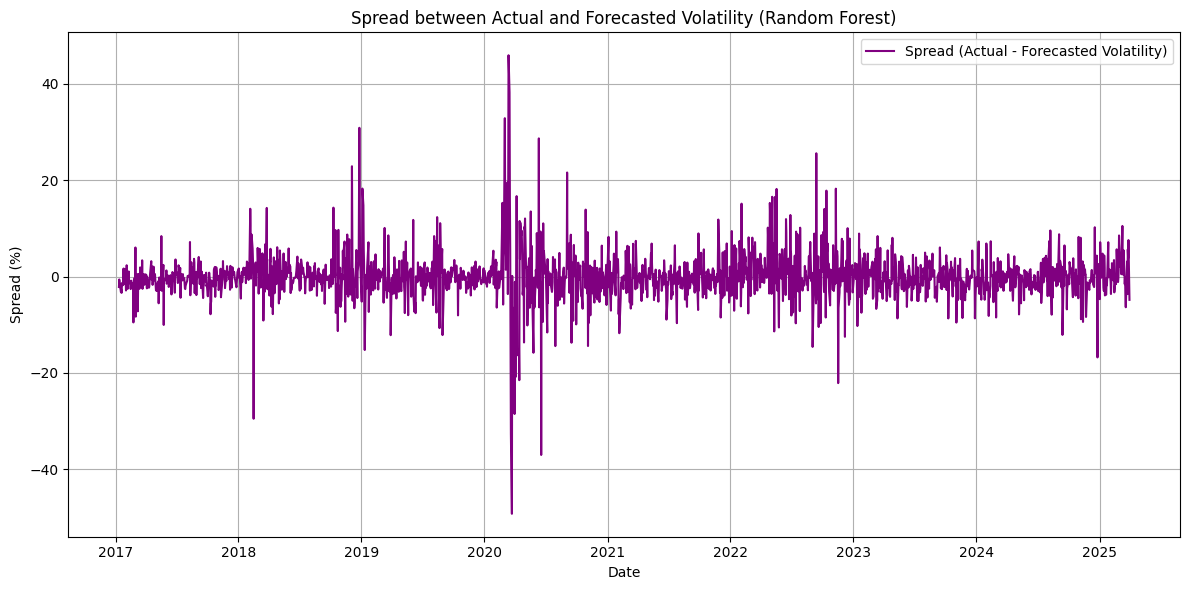

In [16]:
#Plot the spread
spread_rf = actual_series - forecast_series
plt.figure(figsize=(12, 6))
plt.plot(spread_rf, label="Spread (Actual - Forecasted Volatility)", color="purple")
plt.title("Spread between Actual and Forecasted Volatility (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Spread (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Hybrid Approach - Random Forest + GARCH model by using GARCH’s forecast as a feature in the RF model.